In [ ]:
pip install emoji

In [ ]:
pip install langdetect

In [ ]:
pip install  deep_translator

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re
import nltk
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm
import emoji
import spacy
import string
import warnings
warnings.filterwarnings("ignore")
from langdetect import detect, DetectorFactory
from tqdm import tqdm
from deep_translator import GoogleTranslator
tqdm.pandas()

In [ ]:
df=pd.read_excel('P597 DATASET.xlsx')
df.head()

In [ ]:
print("Info:")
print(df.info())

print("\nMissing values in each column:")
print(df.isnull().sum())

print("\nDescriptive statistics (numerical columns):")
print(df.describe())

print("\nDescriptive statistics (object/string columns):")
print(df.describe(include='object'))

In [ ]:
nltk.download('stopwords')
from nltk.corpus import stopwords
stopword_set = set(stopwords.words('english'))
nlp = spacy.load("en_core_web_sm")

In [ ]:
class TextPreprocessor:
    def __init__(self,
                 language='english',
                 remove_stopwords=True,
                 lemmatize=True,
                 remove_emojis=True,
                 translate_to='english'):
        self.language = language
        self.translate_to = translate_to
        self.remove_stopwords = remove_stopwords
        self.lemmatize = lemmatize
        self.translator = GoogleTranslator()
        self.stopwords = set(stopwords.words(language)) if remove_stopwords else set()
        self.lemmatizer = WordNetLemmatizer() if lemmatize else None
        self.remove_emojis = remove_emojis
        self.nlp = spacy.load("en_core_web_sm")

    def detect_language(self, text):
        try:
            return detect(text)
        except:
            return self.language  # fallback

    def translate_text(self, text, dest_lang=None):
        dest = dest_lang if dest_lang else self.translate_to
        try:
            translated = self.translator.translate(text, dest=dest)
            return translated.text
        except:
            return text  # fallback

    def clean_text(self, text):
        text = text.lower()
        if self.remove_emojis:
            text = emoji.replace_emoji(text, replace='')
        text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
        text = re.sub(r'<.*?>', '', text)
        text = text.translate(str.maketrans('', '', string.punctuation))
        text = re.sub(r'\d+', '', text)
        text = re.sub(r'\s+', ' ', text).strip()
        return text

    def tokenize(self, text):
        return [token.text for token in self.nlp(text)]

    def remove_stop_words(self, tokens):
        return [word for word in tokens if word not in self.stopwords]

    def lemmatize_tokens(self, tokens):
        return [self.lemmatizer.lemmatize(word) for word in tokens]

    def preprocess(self, text, detect_and_translate=True):
        if detect_and_translate:
            lang = self.detect_language(text)
            if lang != self.translate_to:
                text = self.translate_text(text, dest_lang=self.translate_to)
        text = self.clean_text(text)
        tokens = self.tokenize(text)
        if self.stopwords:
            tokens = self.remove_stop_words(tokens)
        if self.lemmatizer:
            tokens = self.lemmatize_tokens(tokens)
        return ' '.join(tokens)

In [ ]:
tp = TextPreprocessor()

In [ ]:
df['title_lang'] = df.progress_apply(
    lambda row: tp.detect_language (row['title']),axis=1)
df['body_lang'] = df.progress_apply(
    lambda row: tp.detect_language (row['body']),axis=1)

In [ ]:
df.head()

In [ ]:
df['translated_title'] = df.progress_apply(
    lambda row: tp.translate_text(row['title'], row['title_lang']),
    axis=1
)
df['translated_body'] = df.progress_apply(
    lambda row: tp.translate_text(row['body'], row['body_lang']),
    axis=1
)

In [ ]:
df.head()

In [ ]:
df['text'] = df['translated_title'].astype(str) + ' ' + df['translated_body'].astype(str)

In [ ]:
df.head()

In [ ]:
df['clean_text'] = df['text'].progress_apply(tp.clean_text)

In [ ]:
df['tokens'] = df['clean_text'].progress_apply(tp.tokenize)

In [ ]:
df['tokens_nostop'] = df['tokens'].progress_apply(tp.remove_stop_words)

In [ ]:
import nltk
nltk.download('wordnet')
df['processed_text'] = df['tokens_nostop'].progress_apply(tp.lemmatize_tokens)
df.head()

In [ ]:
from textblob import TextBlob

def get_sentiment(text):
    blob = TextBlob(text)
    polarity = blob.sentiment.polarity
    # Thresholds for polarity: (-1 negative .. 0 neutral .. +1 positive)
    if polarity > 0.1:
        return 'positive'
    elif polarity < -0.1:
        return 'negative'
    else:
        return 'neutral'

df['sentiment'] = df['processed_text'].astype(str).apply(get_sentiment)

print(df[['processed_text', 'sentiment']].sample(5))

In [ ]:
df['sentiment'].value_counts().plot(kind='bar', color=['green', 'red', 'grey'])
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.show()

In [ ]:
df['sentiment'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['green', 'red', 'grey'])
plt.title('Sentiment Proportion')
plt.ylabel('')
plt.show()

In [ ]:
from wordcloud import WordCloud

for sentiment in ['positive', 'negative', 'neutral']:
    text = ' '.join([' '.join(tokens) if isinstance(tokens, list) else str(tokens)
     for tokens in df[df['sentiment'] == sentiment]['processed_text']])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10,4))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {sentiment.capitalize()} Reviews')
    plt.show()

In [ ]:
X = df['processed_text']

In [ ]:
y = df['sentiment'].map({'negative': 0, 'neutral': 1, 'positive': 2})

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer

# Convert list of tokens in X_train to strings
X_train_str = [' '.join(tokens) for tokens in X_train]

# Initialize and fit TfidfVectorizer for SMOTE (using parameters from cell bd91a7e3-938d-4bf6-85d8-327e9859798e)
tfidf_for_smote = TfidfVectorizer(max_features=1000, ngram_range=(1,2))
X_train_tfidf_for_smote = tfidf_for_smote.fit_transform(X_train_str)

# Apply SMOTE to the TF-IDF vectorized data
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_tfidf_for_smote, y_train)

In [ ]:
X_train_str = [' '.join(tokens) for tokens in X_train]
X_test_str = [' '.join(tokens) for tokens in X_test]

tfidf = TfidfVectorizer(max_features=1000, ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(X_train_str)
X_test_tfidf = tfidf.transform(X_test_str)

In [ ]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=300),
    'Naive Bayes': MultinomialNB(),
    'SVM': LinearSVC(max_iter=2000),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(n_estimators=100),
    'KNN': KNeighborsClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
    'MLP': MLPClassifier(max_iter=300)
}

In [ ]:
param_grids = {
    'Logistic Regression': {
        'C': [0.01, 0.1, 1, 10],
        'solver': ['liblinear', 'lbfgs'],
        'max_iter': [100, 300, 500]
    },
    'Naive Bayes': {
        'alpha': [0.5, 1.0, 1.5]
    },
    'SVM': {
        'C': [0.01, 0.1, 1, 10],
        'loss': ['hinge', 'squared_hinge'],
        'max_iter': [1000, 2000, 5000]
    },
    'Decision Tree': {
        'max_depth': [None, 10, 20, 50],
        'min_samples_split': [2, 5, 10],
        'criterion': ['gini', 'entropy']
    },
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 50],
        'min_samples_split': [2, 5, 10]
    },
    'KNN': {
        'n_neighbors': [3, 5, 7, 11],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    },
    'XGBoost': {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 6, 10],
        'learning_rate': [0.01, 0.1, 0.2]
    },
    'MLP': {
        'hidden_layer_sizes': [(50,), (100,), (100,50)],
        'activation': ['relu', 'tanh'],
        'solver': ['adam', 'lbfgs'],
        'max_iter': [200, 300, 500]
    }
}

In [ ]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report


results = {}
cv_scores = {}
test_scores = {}
train_scores = {}
best_classifiers = {}

for name, model in models.items():
    grid = GridSearchCV(
        model,
        param_grid=param_grids.get(name, {}),
        cv=skf,
        scoring='accuracy',
        n_jobs=-1
    )
    grid.fit(X_train_res, y_train_res)
    cv_scores[name] = grid.best_score_
    y_pred = grid.predict(X_test_tfidf)
    test_scores[name] = accuracy_score(y_test, y_pred)
    y_train_pred = grid.predict(X_train_res)
    train_scores[name] = accuracy_score(y_train_res, y_train_pred)
    results[name] = {
        "cv_score": grid.best_score_,
        "train_score": train_scores[name],
        "test_score": test_scores[name],
        "best_params": grid.best_params_,
        "classification_report": classification_report(y_test, y_pred, output_dict=True)
    }
    best_classifiers[name] = grid.best_estimator_

for name in models.keys():
    print(f"Model: {name}")
    print(f"  CV Score: {cv_scores[name]:.4f}")
    print(f"  Train Score: {results[name]['train_score']:.4f}")
    print(f"  Test Score: {test_scores[name]:.4f}")
    print(f"  Best Params: {results[name]['best_params']}")
    class_report = results[name]['classification_report']
    print("  Precision & Recall by Class:")
    for label, metrics in class_report.items():
        if label not in ['accuracy', 'macro avg', 'weighted avg']:
            print(f"{label}: Precision={metrics['precision']:.4f}, Recall={metrics['recall']:.4f}")

In [ ]:
best_model_name = max(test_scores, key=test_scores.get)
model = best_classifiers[best_model_name]

print(f"Best Model: {best_model_name}")
print(f"Best CV Accuracy: {cv_scores[best_model_name]:.4f}")
print(f"Test Accuracy: {test_scores[best_model_name]:.4f}")
print(f"Train Accuracy: {train_scores[best_model_name]:.4f}")

In [41]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
import pandas as pd # Required for pd.Series check in join_tokens

pipe = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=1000, ngram_range=(1,2))), # Use same parameters as used in earlier TF-IDF transformation
    ('clf', model)
])

In [44]:
new_text = "This is an amazing product, I absolutely love it! Highly recommended."

# Preprocess the new text using the existing TextPreprocessor instance
processed_new_text = tp.preprocess(new_text)

print(f"Original text: {new_text}")
print(f"Processed text: {processed_new_text}")

# The pipeline expects a list of strings, so wrap the processed text in a list
prediction = pipe.predict([processed_new_text])

# Map the numerical prediction back to sentiment labels
sentiment_map = {0: 'negative', 1: 'neutral', 2: 'positive'}
predicted_sentiment = sentiment_map[prediction[0]]

print(f"Predicted sentiment: {predicted_sentiment}")

Original text: This is an amazing product, I absolutely love it! Highly recommended.
Processed text: amazing product absolutely love highly recommended
Predicted sentiment: positive


This demonstrates how to use the pipeline for real-time predictions. The `TextPreprocessor` (`tp`) handles the raw text input, and then the trained `pipe` performs the vectorization and classification.

In [45]:
pipe.fit(X_train_str, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=1000, ngram_range=(1, 2))),
                ('clf',
                 MLPClassifier(activation='tanh', hidden_layer_sizes=(100, 50),
                               solver='lbfgs'))])

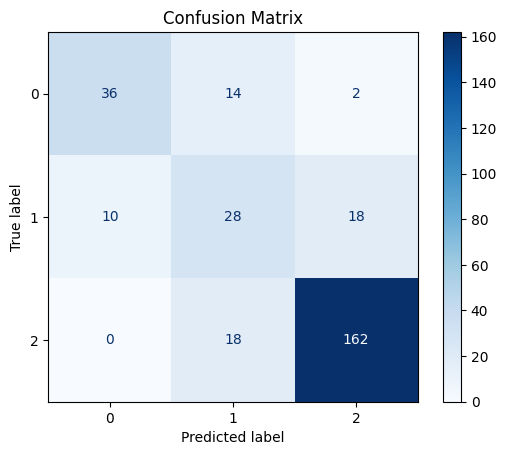

In [46]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predict using the pipeline
y_pred = pipe.predict(X_test_str)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

In [48]:
import joblib
joblib.dump(pipe, 'pipeline.pkl')

['pipeline.pkl']